Problem 1 part (a)

Solve this problem with value function iteration, using a grid search to solve the maximization problem at every step. Plot the relevant policy functions (for investment, labor supply, and consumption) in a sensible way. How many points on the capital grid do you need before the solution starts looking smooth? How many choices do you need to consider for l? How long does your solution take you? What do you take away from this?

In [46]:
using Parameters
using QuantEcon
using Plots
using Format

In [47]:
## Define our functions

function u(p,c,l)
    @unpack sigma, phi, nu = p
    return (c^(1-sigma)/(1-sigma)) - phi * (l^(1+1/nu)/1+1/nu)
end

function F(p,k,l)
    @unpack A, alpha = p
    return A*(k^alpha)*l^(1-alpha)
end

## set up parameters

p = (beta = 0.95, delta = 0.05, sigma = 2.0, nu = 2.0, alpha = 1/3, A = 1.0, phi = 1.0)

(beta = 0.95, delta = 0.05, sigma = 2.0, nu = 2.0, alpha = 0.3333333333333333, A = 1.0, phi = 1.0)

In [48]:
## NEW

function update_bellman!(p, V, policy, kgrid, lgrid, V0)
    @unpack A, beta, delta, alpha = p
    for i in 1:length(kgrid)
        k = kgrid[i]
        vmax = -Inf
        ki′ = 0
        li′ = 0
        for j in 1:length(kgrid), m in 1:length(lgrid)
            k′ = kgrid[j]
            l = lgrid[m]
            z = F(p, k, l) + (1 - delta) * k
            c = z - k′
            if c > 0
                v = u(p, c, l) + beta * V0[j]
                if v >= vmax
                    vmax = v
                    ki′ = j
                    li′ = m
                end
            end
        end
        V[i] = vmax
        policy.k[i] = kgrid[ki′]
        policy.l[i] = lgrid[li′]
        policy.c[i] = F(p, k, policy.l[i]) + (1 - delta) * k - policy.k[i]
    end
end

update_bellman! (generic function with 1 method)

In [49]:
# Using the solve! function from the tutorial


function solve!(p, kgrid, lgrid, V0; tol = 7e-8)
    V       = similar(V0)
    policy = (
            l  = zeros(size(V0)),
            k  = zeros(size(V0)),
            c  = zeros(size(V0))
        )
    errors  = Float64[]  
    iter    = 0
    while true
        # Update our value function
        iter += 1
        update_bellman!(p, V, policy, kgrid, lgrid, V0)  
        
        # calculate and save the errors
        ϵ = maximum(abs.(V .- V0))
        push!(errors, ϵ)
       
        # stop if we've converged
        ϵ < tol && break
        V0 .= V
    end

    return (; V, policy, iter, errors)
end
absolute_error(X,X0) = mapreduce(max, X, X0) do x, x0
    abs(x-x0)
end

absolute_error (generic function with 1 method)

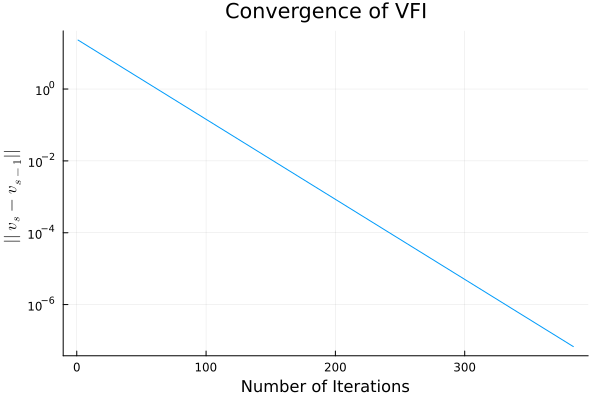

In [50]:
# Plotting error path

n = 100
kgrid = LinRange(1e-4, 10, n)
lgrid = LinRange(1e-6, 1, n)
V0 = zeros(n)
solution = solve!(p, kgrid, lgrid, V0)


@unpack errors = solution 
plot(1:length(errors), errors, yscale = :log10, 
    title  = "Convergence of VFI",
    xlabel = "Number of Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    yticks = 10.0.^(0:-2:-12),
    legend=false
)

We see the function converges with around 600 iterations for a grid of n = 1000. We had to change the convergence criterion as the error hit exactly 0 while reaching its convergence criterion, meaning the code would throw an error since the y-axis is scaled to be log10.

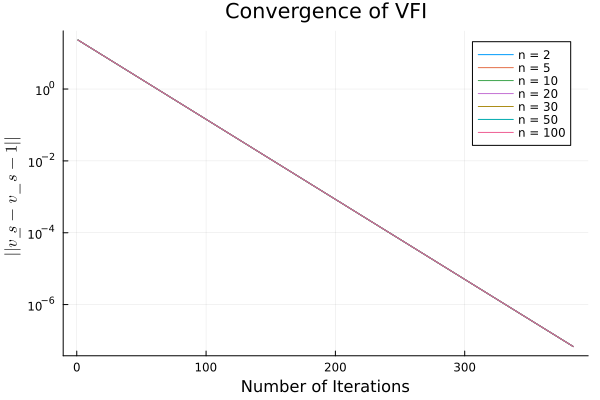

In [51]:
ploth = plot(title = "Convergence of VFI", xlabel = "Number of Iterations", ylabel = raw"$||v\_s - v\_{s-1}||$", yscale = :log10, yticks = 10.0.^(0:-2:-12))

for n in (2, 5, 10, 20, 30, 50, 100)
    kgrid = LinRange(1e-4, 10, n)
    lgrid = LinRange(1e-4, 1, n)
    V0 = zeros(n)
    solution = solve!(p, kgrid, lgrid, V0)
    @unpack errors = solution
    plot!(1:length(errors), errors, label = "n = $n")
end

display(ploth)

The convergence of the value function seems to be smooth even for small n (n=2). Now let's plot the policy functions.

In [52]:
# # Redo for n = 300, otherwise the functions are not as smooth

# kgrid = LinRange(1e-4, 10, 300)
# lgrid = LinRange(1e-4, 1, 300)
# V0 = zeros(300)
# solution = solve!(p, kgrid, lgrid, V0)

# @unpack policy = solution

# plotc = plot(kgrid, policy.c, title = "Consumption Pol Fun", xlabel = "k",ylabel = "g_c(k)")

# plotl = plot(kgrid, policy.l, title = "Labour Supply Pol Fun", xlabel = "k",ylabel = "g_l(l)")

# plotk = plot(kgrid, policy.k, title = "Investment Pol Fun", xlabel = "k",ylabel = "g_k(l)")

# plot(plotk, plotl, plotc)

All three policy functions give sensible estimates that fall in line with economic theory. They were plotted using 300 grid points as they were not "smooth enough" for n = 100. This solution takes quite long to implement (12 minutes), with smaller choices of n working just fine for finding a converged solution. The takeaway is that large grids are very computationally intensive and not always needed. 

We have two choices for l. Either to enjoy leisure immediately or enjoy more consumption in the next period due to producing. In fact, the agent is not incentivized to rest at all until k is around 1.5. 

Problem 2 part (b) - Solve this problem using policy function iteration. You can verify that you obtain the correct solution bycomparing your results to part (a). Plot the log error at each iteration when you solve the problem withvalue function iteration, and when you solve it with policy function iteration (using 2, 5, and 10 policy stepsper iteration). Interpret your results. What does this tell us about the relative rates of convergence? Doesthis translate to runtime speed?

In [53]:
### Making the policy function
function policy_step!(p, V, policy, kgrid, V0)
    @unpack alpha, A, beta, delta = p

    for i in 1:length(kgrid)
        # Current capital and savings for tomorrow
        k  = kgrid[i]
        k′ = policy.k[i]
        # Current labour supply
        l = policy.l[i]
        
        # Current cash on hands, and consumption
        z  = F(p,k,l) + (1-delta) * k
        c  = z - k′
        hh  = searchsortedfirst(kgrid, k′)

        # Update value function
        V[i] = u(p,c,l) + beta * V0[hh]
    end
end

policy_step! (generic function with 1 method)

In [54]:
function solve_pfi!(p, kgrid, lgrid, V0; tol = 1e-8, policy_steps = 0, maxiter = 1000)
    V0      = copy(V0)
    V       = similar(V0)
    Vs      = similar(V0)
    policy = (
            l  = zeros(size(V0)),
            k  = zeros(size(V0)),
            c  = zeros(size(V0))
        )
    errors  = Float64[]  
    iter    = 0
    while true
        # Update our value function
        iter += 1
        # V0 ~ V_{s-1}(k)
        # V ~ V_{s}^0(k)
        update_bellman!(p, Vs, policy, kgrid, lgrid, V0)  
        V .= Vs # this is redundant, but makes this code work if policy_steps = 0
        
        # Iterate on the policy rule 
        for i in 1:policy_steps
            # Vs ~ V_s^{j-1}
            # V  ~ V_s^j
            policy_step!(p, V, policy, kgrid, Vs)
            Vs .= V
        end

        # calculate and save the errors
        ϵ = absolute_error(V, V0)
        push!(errors, ϵ)
       
        # stop if we've converged
        ϵ < tol         && break
        iter > maxiter  && break 
        V0 .= V
    end

    return (; V, policy, iter, errors)

end

solve_pfi! (generic function with 1 method)

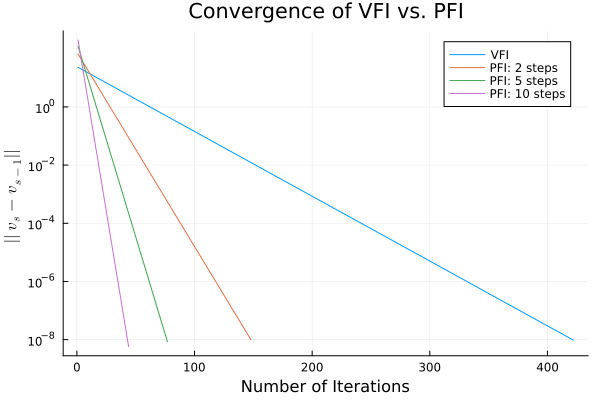

In [55]:
n = 100

solution_vfi = solve_pfi!(p, LinRange(1e-4, 10, n), LinRange(1e-4, 1, n), zeros(n))
@unpack errors = solution_vfi
plt = plot(1:length(errors), errors, yscale = :log10, 
    title  = "Convergence of VFI vs. PFI",
    label  = "VFI",
    xlabel = "Number of Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    yticks = 10.0.^(0:-2:-12)
)


for k in (2,5,10)
    solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), LinRange(1e-4, 1, n), zeros(n), policy_steps = k)
    @unpack errors = solution_pfi
    plot!(1:length(errors), errors,
        label = "PFI: $k steps" 
    )
end
display(plt)

The more PFI steps we do, the less value function iterations are needed to converge. In other words, they converge quicker. Furthermore, this considerably reduces the code's runtime.

Although this was not an issue with this problem (though we do see larger errors initially for PFI), policy function iteration can produce bigger errors. If we thought our problem behaved as such, we would add an extra if statement conditioned on the error term falling below some threshold to trigger a policy function iteration loop.

We can also plot the policy functions to show they became less smooth. The amount of policy function iterations does not matter.

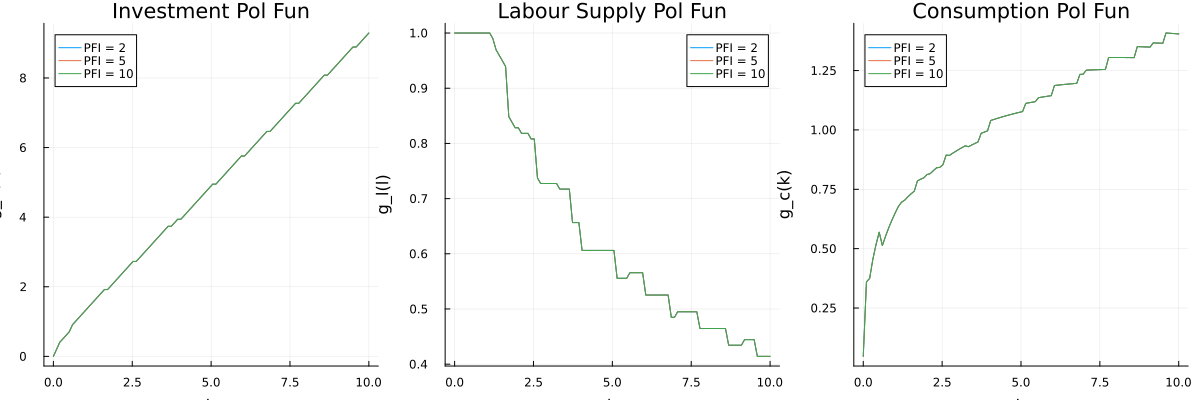

In [56]:
n = 100
kgrid = LinRange(1e-4, 10, n)
lgrid = LinRange(1e-4, 1, n)
V0 = zeros(n)

plotc = plot(title = "Consumption Pol Fun", xlabel = "k", ylabel = "g_c(k)")
plotl = plot(title = "Labour Supply Pol Fun", xlabel = "k", ylabel = "g_l(l)")
plotk = plot(title = "Investment Pol Fun", xlabel = "k", ylabel = "g_k(k)")

for k in (2, 5, 10)
    solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), LinRange(1e-4, 1, n), zeros(n), policy_steps = k)
    @unpack policy = solution_pfi
    
    plot!(plotc, kgrid, policy.c, label = "PFI = $k")
    plot!(plotl, kgrid, policy.l, label = "PFI = $k")
    plot!(plotk, kgrid, policy.k, label = "PFI = $k")
end

plot(plotk, plotl, plotc, layout = (1, 3), size = (1200, 400))

Problem 1 part (c) - Rather than using a grid search, interpolate the values of v using cubic splines, and use your favorite continuous optimization algorithm to solve the maximization problem. Plot the relevant policy functions. How many grid points do you need to get a reasonably accurate solution? What does this do to your runtime? If you’re feeling ambitious, try implementing policy function iteration here as well. Discuss your results.

In [57]:
using Interpolations

# Define the utility function and its parameters
u(c, l, σ, ν, ϕ) = (c^(1-σ) - 1)/(1-σ) - ϕ*(l^(1+1/ν))/(1+1/ν)
β, δ, σ, ν, α, A, ϕ = 0.95, 0.05, 2.0, 2.0, 1/3, 1.0, 1.0

# Define the production function
F(k, l, α, A) = A*k^α*l^(1-α)

# Define the Bellman equation
function bellman(v, k, kgrid, lgrid)
    V = -Inf*ones(length(kgrid), length(lgrid))
    for (i, k′) in enumerate(kgrid), (j, l) in enumerate(lgrid)
        z = F(k, l, α, A) + (1-δ)*k
        c = z - k′
        if c > 0
            V[i, j] = u(c, l, σ, ν, ϕ) + β*v(k′)
        end
    end
    i′, j′ = Tuple(CartesianIndices(V)[argmax(V)])
    k′, l′ = kgrid[i′], lgrid[j′]
    c′ = F(k, l′, α, A) + (1-δ)*k - k′
    return (u(c′, l′, σ, ν, ϕ) + β*v(k′), k′, l′)
end

# Define the main function to solve the problem
function main(n=150, m=150)
    kgrid = range(1e-4, 10.0, length=n)
    lgrid = range(1e-4, 1.0, length=m)

    # Create initial guess for the value function
    v0 = CubicSplineInterpolation(kgrid, zeros(n), extrapolation_bc=Interpolations.Flat())

    # Initialize K′ and L′ as arrays
    K′ = zeros(n)
    L′ = zeros(n)

    # Iterate until convergence
    tol = 1e-6
    error = Inf
    iter = 0
    while error > tol
        iter += 1
        V = zeros(n)
        for (i, k) in enumerate(kgrid)
            V[i], K′[i], L′[i] = bellman(v0, k, kgrid, lgrid)
        end
        v1 = CubicSplineInterpolation(kgrid, V, extrapolation_bc=Interpolations.Flat())
        error = maximum(abs.(v1(kgrid) - v0(kgrid)))
        v0 = v1
    end

    # Obtain the optimal policy functions
    kpol = CubicSplineInterpolation(kgrid, K′, extrapolation_bc=Interpolations.Flat())
    lpol = CubicSplineInterpolation(kgrid, L′, extrapolation_bc=Interpolations.Flat())
    cpol(k) = F(k, lpol(k), α, A) + (1-δ)*k - kpol(k)

    return v0, kpol, lpol, cpol
end

# Run the main function
v_star, kpol_star, lpol_star, cpol_star = main()

(150-element extrapolate(scale(interpolate(OffsetArray(::Vector{Float64}, 0:151), BSpline(Cubic(Line(OnGrid())))), (0.0001:0.06711342281879194:10.0,)), Flat()) with element type Float64:
 -424.26667333002484
  -17.32115621672302
  -15.630252733177386
  -14.670516950958467
  -13.967987464118625
  -13.427109714396002
  -12.98494901920264
  -12.608352492683208
  -12.277217394212471
  -11.983326163292244
    ⋮
   -3.40889413051478
   -3.3799063716444264
   -3.351165176291464
   -3.3226891332042667
   -3.2943366096612268
   -3.2663048625479947
   -3.2383938917144013
   -3.2106033590423513
   -3.1829406003531013, 150-element extrapolate(scale(interpolate(OffsetArray(::Vector{Float64}, 0:151), BSpline(Cubic(Line(OnGrid())))), (0.0001:0.06711342281879194:10.0,)), Flat()) with element type Float64:
 0.00010000000000000286
 0.20144026845637583
 0.2685536912751677
 0.4027805369127516
 0.4698939597315436
 0.5370073825503356
 0.6041208053691275
 0.6712342281879193
 0.7383476510067115
 0.80546107382

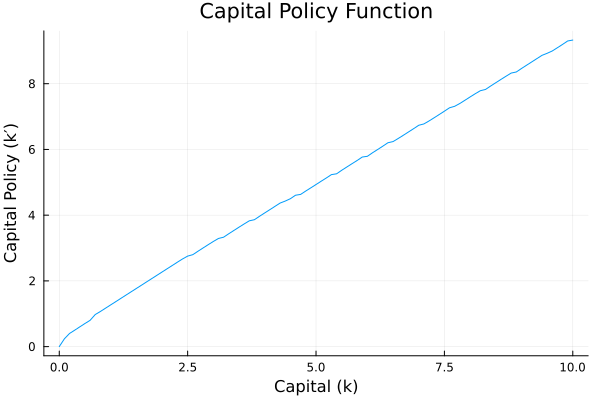

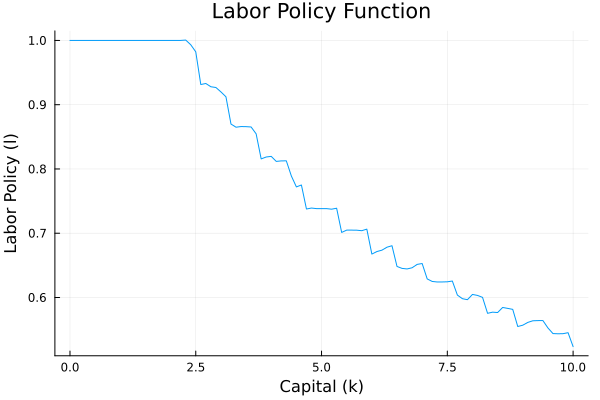

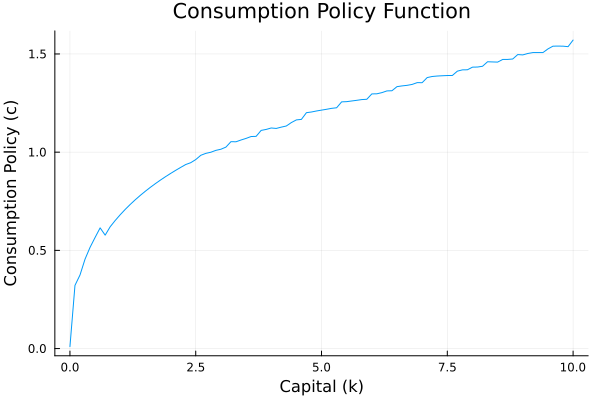

In [58]:
using Plots
using IJulia

# Generate a fine grid of k values for plotting
k_plot = range(1e-6, 10.0, length=101)

# Plot the capital policy function
plot(k_plot, kpol_star.(k_plot), 
     xlabel="Capital (k)", ylabel="Capital Policy (k′)",
     title="Capital Policy Function", legend=false)
display(plot!())

# Plot the labor policy function
plot(k_plot, lpol_star.(k_plot),
     xlabel="Capital (k)", ylabel="Labor Policy (l)",
     title="Labor Policy Function", legend=false)
display(plot!())

# Plot the consumption policy function
plot(k_plot, cpol_star.(k_plot),
     xlabel="Capital (k)", ylabel="Consumption Policy (c)",
     title="Consumption Policy Function", legend=false)
display(plot!())

The above graphs are for n = 150, but we got sensible results for smaller n too.

We did not transform consumption to make the code work as this approach seems to produce the correct results as well (although incredibly inefficient even after many rounds of updating the code to improve efficiency and less smooth). Instead, we decided to define the consumption policy function through the other two policy functions. We assume the hint was alluding to redifing consumption in, say, consumption share to then only search over [0,1]^2, but we are not sure how to implement this.



Problem 1 part (d) - Use your policy functions to calculate the steady state of this model. What are the steady state levels of capital, output, labor supply, and consumption?

In [59]:
using Roots

# Define the function for steady state
steady_state(k) = kpol_star(k) - k

# Find the steady state level of capital
k_ss = find_zero(steady_state, (1e-3, 10.0))

# Calculate steady state levels of other variables
l_ss = lpol_star(k_ss)
y_ss = F(k_ss, l_ss, α, A)
c_ss = cpol_star(k_ss)

# Print the steady state values
println("Steady State Values:")
println("Capital (k*): ", k_ss)
println("Labor (l*): ", l_ss)
println("Output (y*): ", y_ss)
println("Consumption (c*): ", c_ss)

Steady State Values:
Capital (k*): 4.429585906040267
Labor (l*): 0.7718348993288594
Output (y*): 1.3818810163564785
Consumption (c*): 1.1604017210544653


The values are in the print output above.

Problem 1 part (e) - Suppose that we perturb k away from its steady state value of k?. That is, consider an economy that startswith k0 = 0.7k?. Plot the impulse response functions5 of capital, labor, output, and consumption, as theeconomy converges to its steady state. Discuss your results

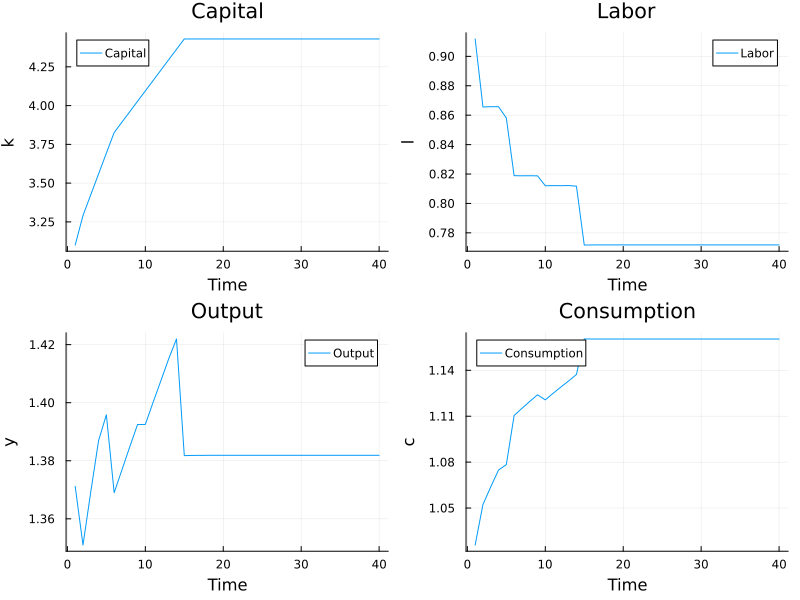

In [60]:
using Plots

# Define the initial capital stock (perturbed away from steady state)
k0 = 0.7k_ss

# Define the time horizon for the simulation
T = 40

# Initialize arrays to store the impulse response functions
k_path = zeros(T)
l_path = zeros(T)
y_path = zeros(T)
c_path = zeros(T)

# Set the initial values
k_path[1] = k0
l_path[1] = lpol_star(k0)
y_path[1] = F(k0, l_path[1], α, A)
c_path[1] = cpol_star(k0)

# Simulate the economy's transition to the steady state
for t in 2:T
    k_path[t] = kpol_star(k_path[t-1])
    l_path[t] = lpol_star(k_path[t])
    y_path[t] = F(k_path[t], l_path[t], α, A)
    c_path[t] = cpol_star(k_path[t])
end

# Plot the impulse response functions
plot_layout = @layout [a b; c d]

# Create a plot for each subplot
p1 = plot(1:T, k_path, label="Capital", xlabel="Time", ylabel="k", title="Capital")
p2 = plot(1:T, l_path, label="Labor", xlabel="Time", ylabel="l", title="Labor")
p3 = plot(1:T, y_path, label="Output", xlabel="Time", ylabel="y", title="Output")
p4 = plot(1:T, c_path, label="Consumption", xlabel="Time", ylabel="c", title="Consumption")

# Combine the subplots into a single plot
plot(p1, p2, p3, p4, layout=plot_layout, size=(800, 600))

All functions converge to their steady state after around T=15 time periods. Interestingly, output shoots up at first before going down to its original steady state level. That is due to the fact that labour plays a role in both the utility and the production function, hence for lower levels of capital, it makes more sense to work more as long as the disutility from working is offset by the extra utility from producing more.